<a href="https://colab.research.google.com/github/a01137646/NA_ProyectoFinal_Equipo_21/blob/main/Proyecto_Final_Equipo21_borrador8_udacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import glob
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, MaxPooling2D

In [4]:
#datadir = './Documents/GitHub/NA_ProyectoFinal_Equipo_21/LAPS/'
datadir = 'C:/Users/G/Documents/GitHub/NA_ProyectoFinal_Equipo_21/LAPS/'
list_folders = glob.glob(datadir + '*')

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.DataFrame()
for path in list_folders:
    data_temp = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    data = pd.concat([data,data_temp], ignore_index=True)

#del(data_temp)
print('Cantidad de registros:',len(data.index))
data.head()

Cantidad de registros: 12864


center  \
0  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
1  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
2  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
3  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
4  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   

                                                left  \
0   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
1   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
2   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
3   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
4   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   

                                               right  steering  throttle  \
0   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
1   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
2   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
3   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
4   C:\Users\G\Documents\TEC\Maestria\5 abril-jul... -0.012859       0.0   

   reverse     speed  
0        0  1.769504  
1        0  1.747100  
2        0  1.724921  
3        0  1.702988  
4        0  1.681361

In [5]:
def path_leaf(path):
    return '/'.join(path.split('\\')[-3:])

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  \
0  EXTRAS/IMG/center_2023_06_18_11_34_10_192.jpg   
1  EXTRAS/IMG/center_2023_06_18_11_34_10_294.jpg   
2  EXTRAS/IMG/center_2023_06_18_11_34_10_396.jpg   
3  EXTRAS/IMG/center_2023_06_18_11_34_10_498.jpg   
4  EXTRAS/IMG/center_2023_06_18_11_34_10_600.jpg   

                                          left  \
0  EXTRAS/IMG/left_2023_06_18_11_34_10_192.jpg   
1  EXTRAS/IMG/left_2023_06_18_11_34_10_294.jpg   
2  EXTRAS/IMG/left_2023_06_18_11_34_10_396.jpg   
3  EXTRAS/IMG/left_2023_06_18_11_34_10_498.jpg   
4  EXTRAS/IMG/left_2023_06_18_11_34_10_600.jpg   

                                          right  steering  throttle  reverse  \
0  EXTRAS/IMG/right_2023_06_18_11_34_10_192.jpg  0.000000       0.0        0   
1  EXTRAS/IMG/right_2023_06_18_11_34_10_294.jpg  0.000000       0.0        0   
2  EXTRAS/IMG/right_2023_06_18_11_34_10_396.jpg  0.000000       0.0        0   
3  EXTRAS/IMG/right_2023_06_18_11_34_10_498.jpg  0.000000       0.0        0   
4  EXTRAS/IMG/right_2023_06_18_11_34_10_600.jpg -0.012859       0.0        0   

      speed  
0  1.769504  
1  1.747100  
2  1.724921  
3  1.702988  
4  1.681361

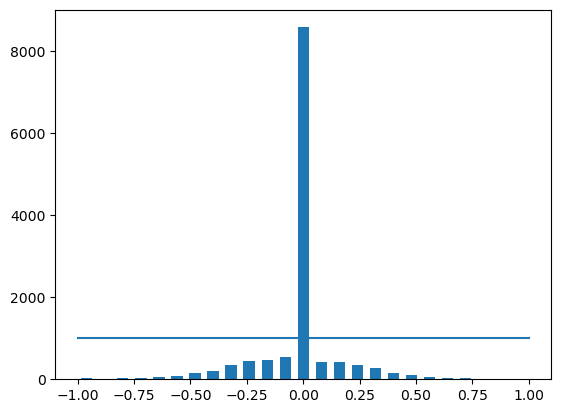

In [6]:
num_bins = 25

samples_per_bin = 1000

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 12864
removed: 7583
remaining: 5281


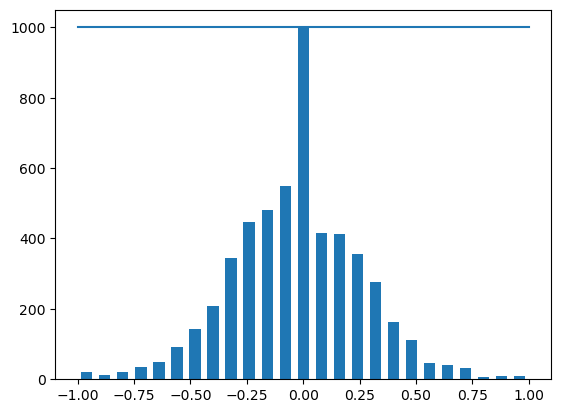

In [7]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
#print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        #center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        center = indexed_data[0]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        #image_path.append(os.path.join(datadir,left.strip()))
        #steering.append(float(indexed_data[3])+0.15)
        # right image append
        #image_path.append(os.path.join(datadir,right.strip()))
        #steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir, data)

In [9]:
def img_perspective(image, steering, orientation, angle, multiplier):
    height,width, ch = image.shape

    if orientation == 'left':
        pts1 = np.float32([[0,0],[0,height],[width,height-height*angle],[width,height*angle]])
        pts2 = np.float32([[0,0],[0,height],[width,height],[width,0]])
        #steering = steering - angle*multiplier
        steering = steering - multiplier
    else:
        pts1 = np.float32([[0,height*angle],[0,height-height*angle],[width,height],[width,0]])
        pts2 = np.float32([[0,0],[0,height],[width,height],[width,0]])
        #steering = steering + angle*multiplier
        steering = steering + multiplier
    M = cv2.getPerspectiveTransform(pts1,pts2)
    image = cv2.warpPerspective(image,M,(width,height))
    return image, steering

def img_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

def img_rotate_ang(image, steering, orientation, angle):
    if orientation == 'left':
        aug = iaa.Rotate(-angle)
        steering = steering - math.radians(angle)
    else:
        aug = iaa.Rotate(angle)
        steering = steering + math.radians(angle)
    image = aug.augment_image(image)
    return image, steering

In [10]:
image_paths_temp = list(image_paths)
steerings_temp = list(steerings)

for i in range(len(image_paths)):
    img = mpimg.imread(image_paths[i])
    #if steerings[i] == 0:
        #rand1 = random.randrange(25, 35)/100
        #img_left_1, steering_left_1 = img_perspective(img,steerings[i],'left',rand1,rand1)
        #img_right_1, steering_right_1 = img_perspective(img,steerings[i],'right',rand1,rand1)
        #path_left_1 = image_paths[i][:-4]+'_left_1'+image_paths[i][-4:]
        #path_right_1 = image_paths[i][:-4]+'_right_1'+image_paths[i][-4:]
        #mpimg.imsave(path_left_1,img_left_1); image_paths_temp.append(path_left_1); steerings_temp.append(steering_left_1)
        #mpimg.imsave(path_right_1,img_right_1); image_paths_temp.append(path_right_1); steerings_temp.append(steering_right_1)
        #rand2 = random.randrange(35, 45)/100
        #img_left_2, steering_left_2 = img_perspective(img,steerings[i],'left',rand2,rand2)
        #img_right_2, steering_right_2 = img_perspective(img,steerings[i],'right',rand2,rand2)
        #path_left_2 = image_paths[i][:-4]+'_left_2'+image_paths[i][-4:]
        #path_right_2 = image_paths[i][:-4]+'_right_2'+image_paths[i][-4:]
        #mpimg.imsave(path_left_2,img_left_2); image_paths_temp.append(path_left_2); steerings_temp.append(steering_left_2)
        #mpimg.imsave(path_right_2,img_right_2); image_paths_temp.append(path_right_2); steerings_temp.append(steering_right_2)


    #img_left1, steering_left1 = img_rotate_ang(img,steerings[i],'left',15)
    #img_right1, steering_right1 = img_rotate_ang(img,steerings[i],'right',15)
    #path_left1 = image_paths[i][:-4]+'_left_1'+image_paths[i][-4:]
    #path_right1 = image_paths[i][:-4]+'_right_1'+image_paths[i][-4:]
    #mpimg.imsave(path_left1,img_left1); image_paths_temp.append(path_left1); steerings_temp.append(steering_left1)
    #mpimg.imsave(path_right1,img_right1); image_paths_temp.append(path_right1); steerings_temp.append(steering_right1)
    #img_left2, steering_left2 = img_rotate_ang(img,steerings[i],'left',25)
    #img_right2, steering_right2 = img_rotate_ang(img,steerings[i],'right',25)
    #path_left2 = image_paths[i][:-4]+'_left_2'+image_paths[i][-4:]
    #path_right2 = image_paths[i][:-4]+'_right_2'+image_paths[i][-4:]
    #mpimg.imsave(path_left2,img_left1); image_paths_temp.append(path_left2); steerings_temp.append(steering_left2)
    #mpimg.imsave(path_right2,img_right1); image_paths_temp.append(path_right2); steerings_temp.append(steering_right2)


length = len(image_paths)
for i in range(length):
    if steerings_temp[i] != 0:
        img_path = image_paths_temp[i]
        img = mpimg.imread(img_path)
        img, new_steering = img_flip(img,steerings_temp[i])
        new_path = img_path[:-4]+'_flipped'+img_path[-4:]
        mpimg.imsave(new_path,img)
        image_paths_temp.append(new_path); steerings_temp.append(new_steering)

image_paths = np.array(image_paths_temp)
steerings = np.array(steerings_temp)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 7696
Valid Samples: 1925


Text(0.5, 1.0, 'Validation set')

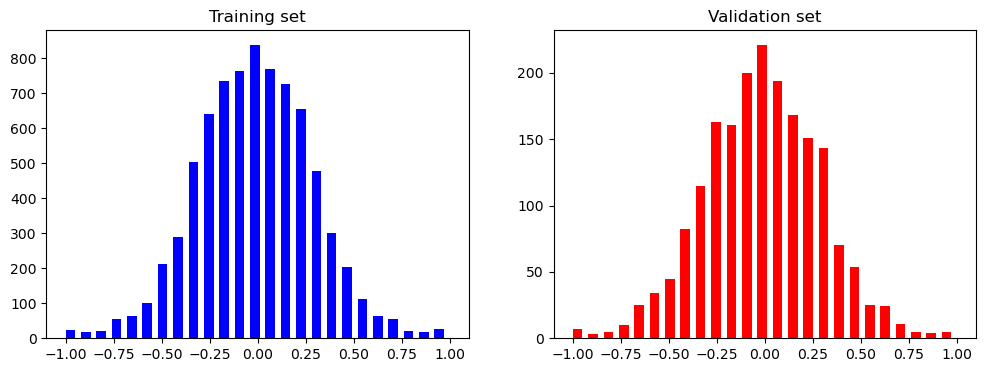

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

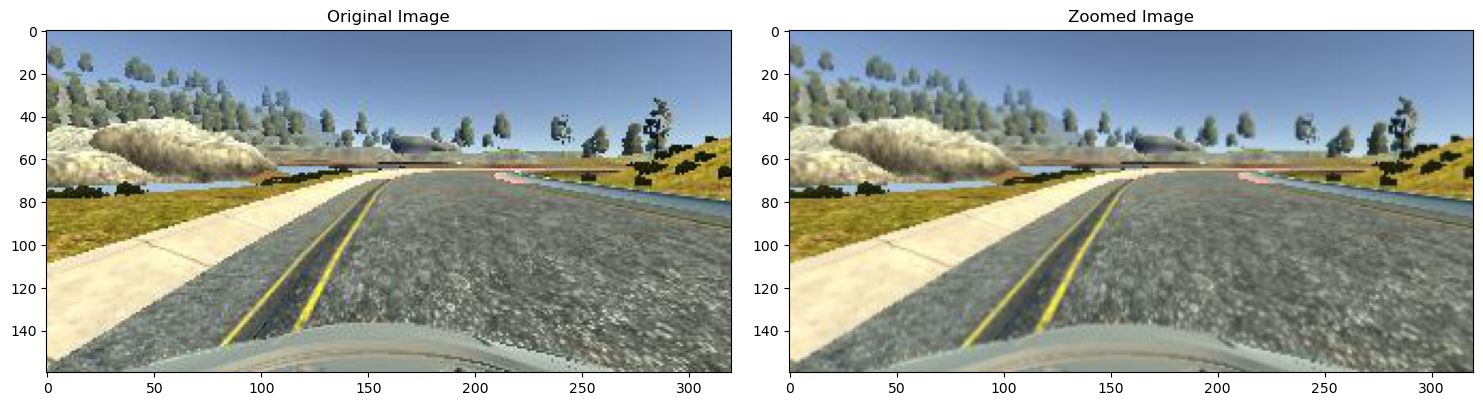

In [13]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.15))
    image = zoom.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

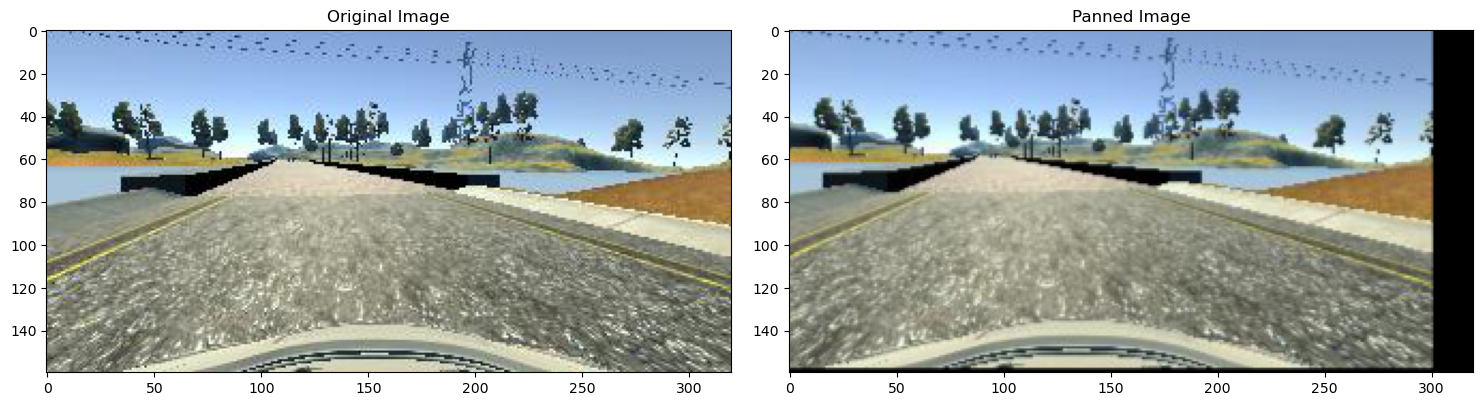

In [17]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

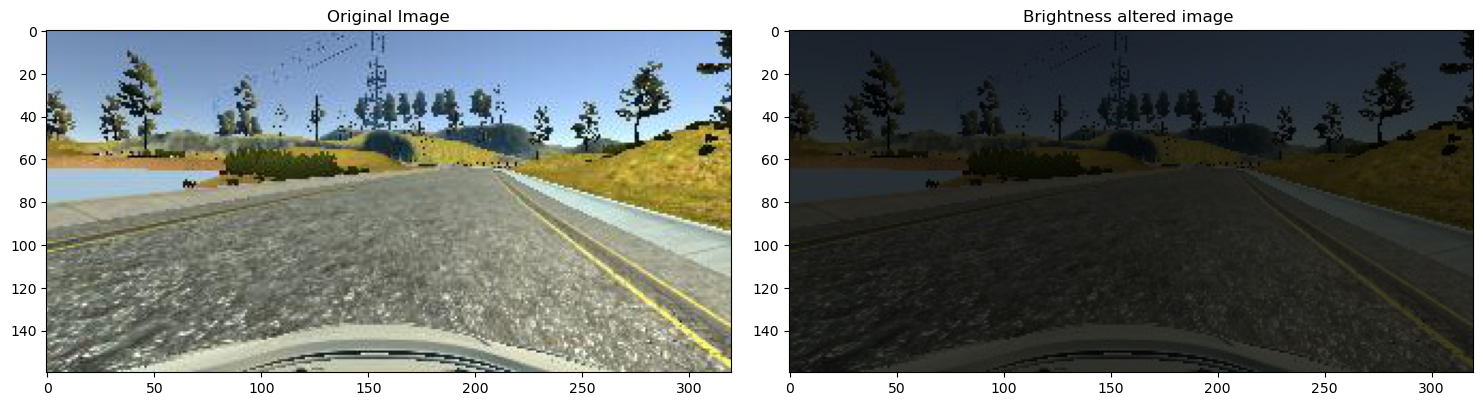

In [20]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.1331577')

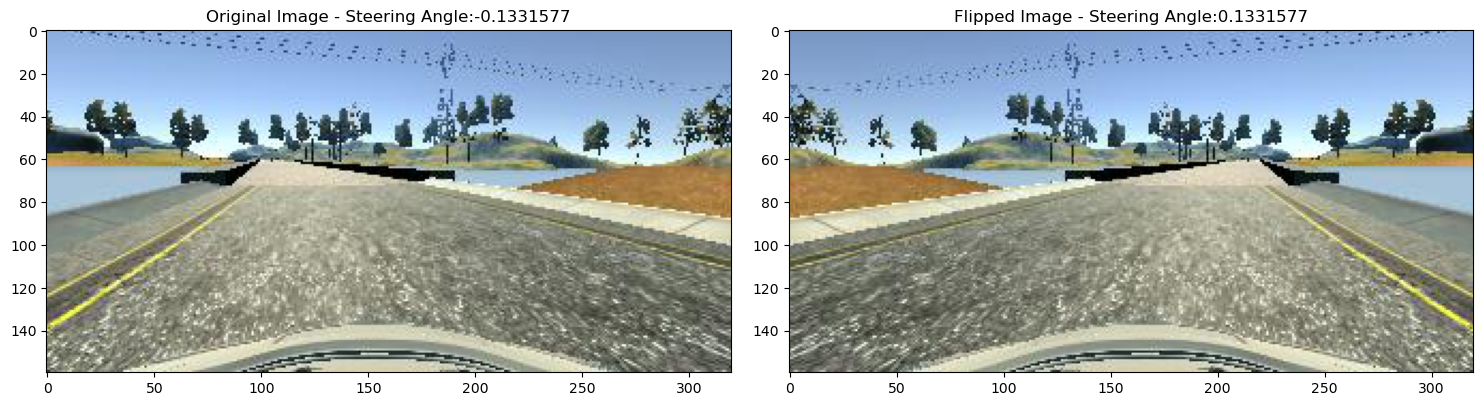

In [22]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

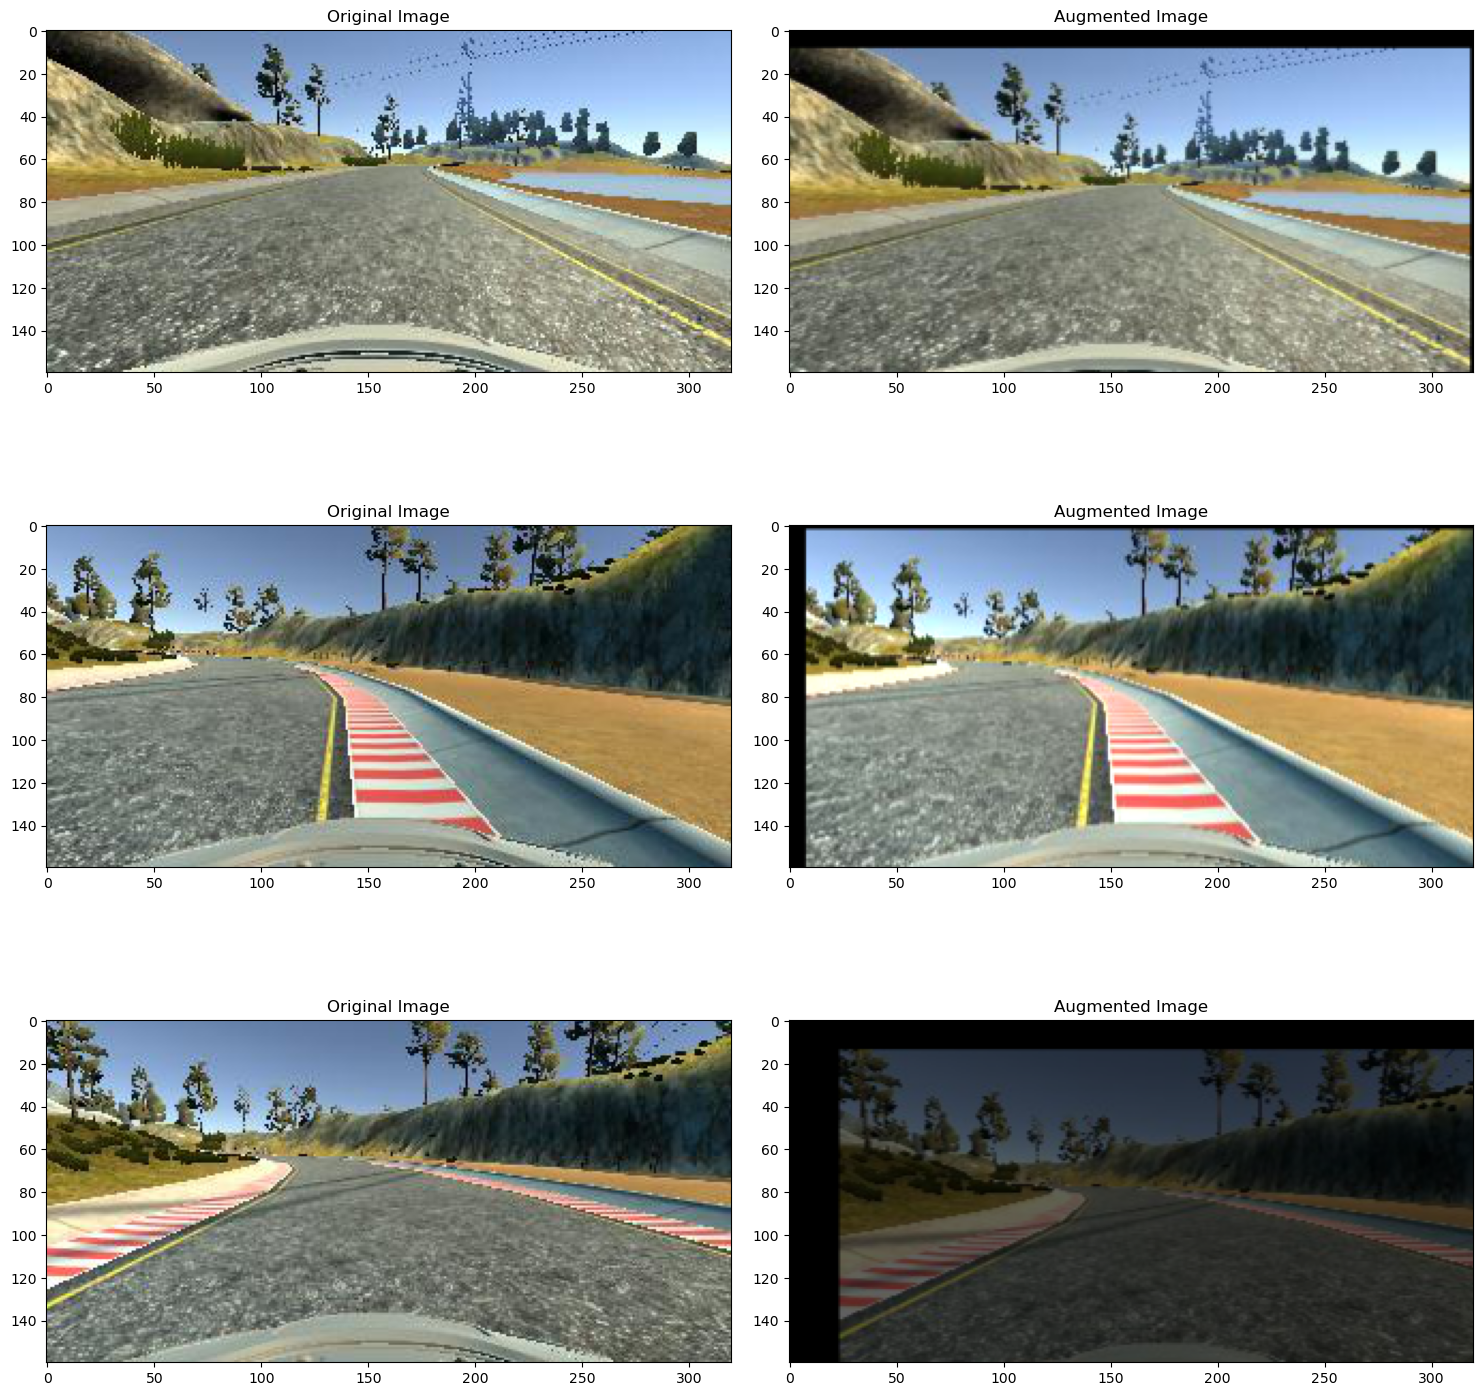

In [23]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    #if np.random.rand() < 0.5:
    #    image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle


ncol = 2
nrow = 3

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

Text(0.5, 1.0, 'Preprocessed Image')

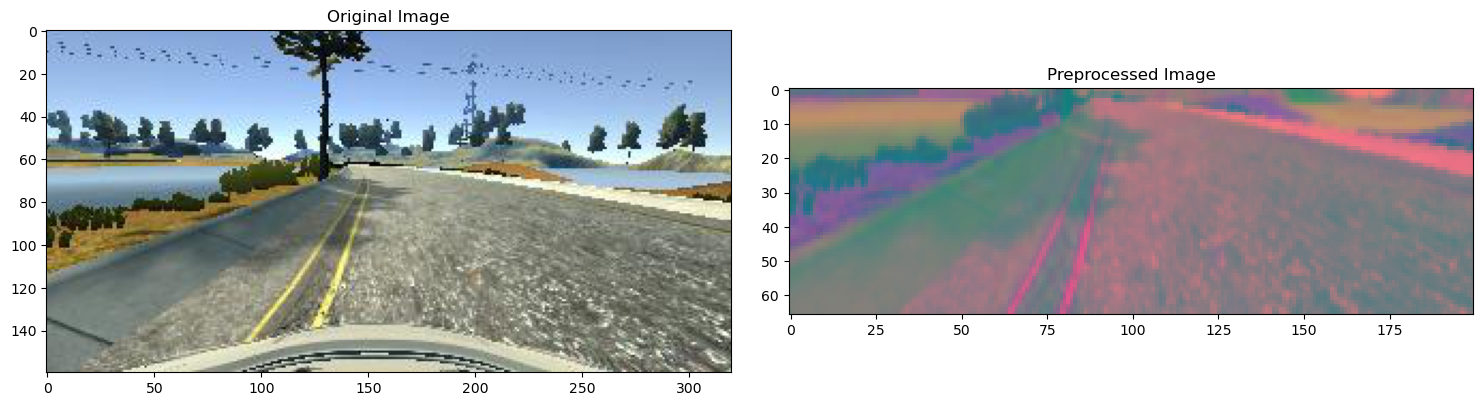

In [24]:
def img_preprocess(img):
    img = img[60:135,:,:]
    #brightness = iaa.Multiply(1.5)
    #img = brightness.augment_image(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    img = tf.convert_to_tensor(img)

    return img

image = image_paths[300]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [25]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img =[]
        batch_steering = []

        for i in range(batch_size):

            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

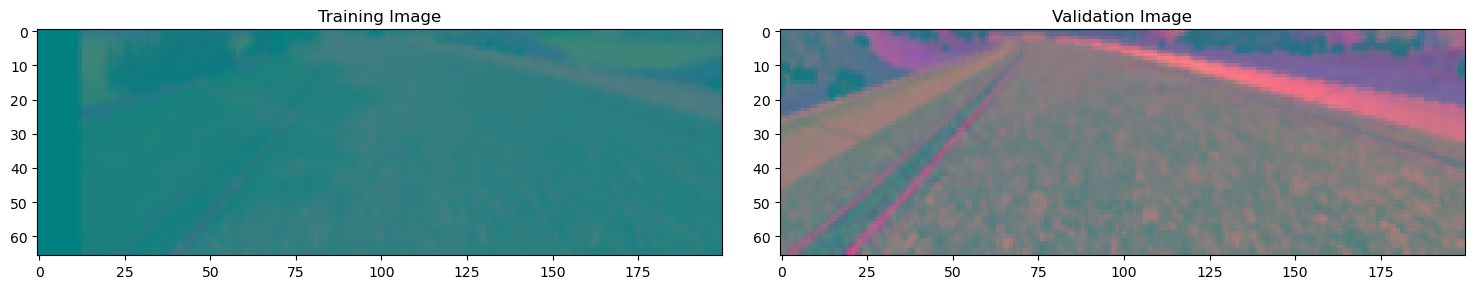

In [28]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [29]:
def nvidia_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 24, kernel_size = (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 36, kernel_size = (5, 5), strides=(2, 2), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 48, kernel_size = (5, 5), strides=(2, 2), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='elu'))


    model.add(tf.keras.layers.Convolution2D(filters = 64, kernel_size = (3, 3), activation='elu'))
    model.add(tf.keras.layers.Dropout(0.25))


    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(100, activation = 'elu'))

    model.add(tf.keras.layers.Dense(50, activation = 'elu'))


    model.add(tf.keras.layers.Dense(10, activation = 'elu'))


    model.add(tf.keras.layers.Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [30]:
model = nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [31]:
def calculate_spe(y):
    return int(math.ceil((1. * y) / batch_size))

In [32]:
batch_size = 32

In [33]:
history = model.fit(batch_generator(X_train, y_train, batch_size, 1),
                              steps_per_epoch=calculate_spe(len(X_train)),
                              epochs=14,
                              validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
                              validation_steps= calculate_spe(len(X_valid)),
                              verbose=1,
                              shuffle = 1)

Epoch 1/14
241/241 [==============================] - 31s 116ms/step - loss: 0.0976 - val_loss: 0.0605
Epoch 2/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0683 - val_loss: 0.0565
Epoch 3/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0680 - val_loss: 0.0518
Epoch 4/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0586 - val_loss: 0.0447
Epoch 5/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0548 - val_loss: 0.0440
Epoch 6/14
241/241 [==============================] - 30s 123ms/step - loss: 0.0517 - val_loss: 0.0461
Epoch 7/14
241/241 [==============================] - 29s 123ms/step - loss: 0.0498 - val_loss: 0.0437
Epoch 8/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0474 - val_loss: 0.0415
Epoch 9/14
241/241 [==============================] - 27s 111ms/step - loss: 0.0470 - val_loss: 0.0383
Epoch 10/14
241/241 [==============================] - 29s 123ms/step - l

Text(0.5, 0, 'Epoch')

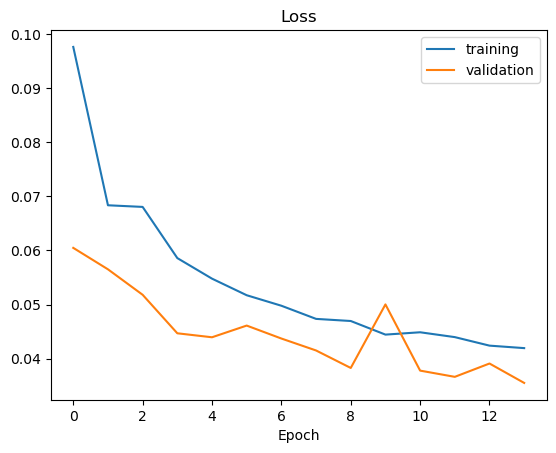

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [37]:
#model.save('./Documents/GitHub/NA_ProyectoFinal_Equipo_21/model_8.h5')
model.save('C:/Users/G/Documents/GitHub/NA_ProyectoFinal_Equipo_21/model_8.h5')

In [6]:
import socketio
import eventlet
import numpy as np
from flask import Flask
#from keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model

In [7]:
sio = socketio.Server()

app = Flask(__name__) #'__main__'
speed_limit = 60
def img_preprocess(img):
    img = img[60:135,:,:]
    #brightness = iaa.Multiply(1.5)
    #img = brightness.augment_image(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    img = tf.convert_to_tensor(img)
    #img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    #brightness = iaa.Multiply((0.5, 0.5))
    #img = brightness.augment_image(img)
    #img = cv2.GaussianBlur(img,(3,3),0,0)
    #img = cv2.resize(img, (200, 66))
    #img = img/255
    return img

In [8]:
@sio.on('telemetry')
def telemetry(sid, data):
    #print(np.asarray(Image.open(BytesIO(base64.b64decode(data['image'])))))
    speed = float(data['speed'])
    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = img_preprocess(image)
    image = np.array([image])
    steering_angle = float(model.predict(image,verbose = 0))
    throttle = 1.0 - speed/speed_limit
    #print('{} {} {}'.format(steering_angle, throttle, speed))
    send_control(steering_angle, throttle)

In [9]:
@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    send_control(0, 0)

def send_control(steering_angle, throttle):
    sio.emit('steer', data = {
        'steering_angle': steering_angle.__str__(),
        'throttle': throttle.__str__()
    })

In [10]:
if __name__ == '__main__':
    #model = load_model('./Documents/GitHub/NA_ProyectoFinal_Equipo_21/model_8.h5')
    model = load_model('C:/Users/G/Documents/GitHub/NA_ProyectoFinal_Equipo_21/model_8.h5')
    app = socketio.Middleware(sio, app)
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

(1204) wsgi starting up on http://0.0.0.0:4567
(1204) accepted ('127.0.0.1', 50805)


Connected


wsgi exiting
127.0.0.1 - - [18/Jun/2023 16:42:03] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 173.269845
(1204) wsgi exited, is_accepting=True
